# Objective.

This notebook computationally implements error propagation for the z-scan technique.

In [36]:
# LIBRERIAS
import matplotlib
import numpy as np
import sympy as sym
import matplotlib.pylab as plt


%matplotlib inline 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

#to en otra carpeta
#sns.set_theme()

# Función ajustar
def fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+(z/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T



# Parameters

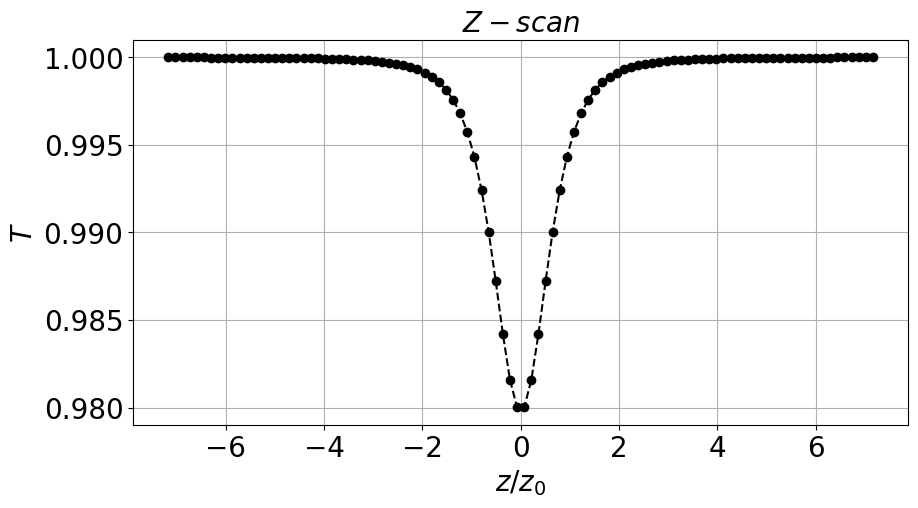

In [37]:
fig=plt.figure(figsize=(10,5))

beta_e = 3.4e-11 # TPA seed in (m/W )
L_e= 1e-3 # thickness in (m).
Pavg_e = 200e-3# Average power in (W)
Tp_e =  200e-15 # pulse width FWHM in (s)
wl_e =790e-9 #central wavelength in (m)
D_e = 2e-3 # beam diameter in (m)
focal_e =15e-2 # Distance EFTL-sample (m)a
Cf_e = 1.36 # beam correction coeff
alfa_e = 2.6e-1 # linear absorption in (1/m) 
R_e =0.33 # reflection percentage 
freq_e = 90.6e6#Frecuencia en HZ
w0_e = 2.0*wl_e*focal_e*Cf_e/(np.pi*D_e) # beam waist
z0 = np.pi*w0_e**2/wl_e # Rayleigh range
z_e=np.linspace(-1/2*focal_e,1/2*focal_e,100)#focal distance [m]
T_e=list(fscanTH2(z_e,focal_e,beta_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e)) #Señal simulada
val_min=min(T_e)
index=T_e.index(min(T_e))
plt.plot(z_e/z0,T_e,'--ko',label='simulated signal')
plt.title('$Z-scan$',fontsize=20)
plt.xlabel('$z/z_0$',fontsize=20)
plt.ylabel('$T$',fontsize=20)
plt.grid()
#plt.plot(corriente,Td,'--ro',label='derivada')

# Method 1

In [42]:
T,z, f,L,P,Tp,wl,D,Cf,alfa,R,freq = sym.symbols('T z f L P Tp wl D Cf alfa R freq')
params=[T,z,f,L,P,Tp,wl,D,Cf,alfa,R,freq]

# Función ajustar
def BETA(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - sym.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(sym.pi*D) # beam waist
    z0 = sym.pi*w0**2/wl # Rayleigh range
    w = w0*sym.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*sym.sqrt(np.log(2))*Pavg/(Tp*freq*sym.pi**1.5*w**2) # Peak intensity at sample 
    # Transmitance
    b=(1-trans)*(1/(2*sym.sqrt(2))*(1-R)*I0*Leff/(1+(z/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def BETA_prime(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq,param):
    return sym.diff(BETA(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq),param,1)


#print(BETA_prime(T,f,L,P,Tp,wl,D,ds,Cf,alfa,R,freq,params[0])) #This works.

DerivativeOfF = sym.lambdify((T,z, f,L,P,Tp,wl,D,Cf,alfa,R,freq),BETA_prime(T,z, f,L,P,Tp,wl,D,Cf,alfa,R,freq,params[0]),"numpy")

#print(DerivativeOfF(1,1,1))

# Separate effect.

For method 1 the error propagation formula tells us:

$$\sigma^{2}=\left(\frac{\partial \beta}{\partial x} \sigma_{X}\right)^{2}+\left(\frac{\partial \beta}{\partial y} \sigma_{Y}\right)^{2}+\sum_{i=1}^{N}\left(\frac{\partial \beta}{\partial v_i} \sigma_{V_i}\right)^{2}$$


We calculate the derivatives separately:

In [43]:
results=[]

for i in range(0,len(params)):
    DerivativeOfF = sym.lambdify((T,z, f,L,P,Tp,wl,D,Cf,alfa,R,freq),BETA_prime(T,z, f,L,P,Tp,wl,D,Cf,alfa,R,freq,params[i]),"numpy")
    val=DerivativeOfF(T_e[index],z_e[index],focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e)
    results.append(abs(val))

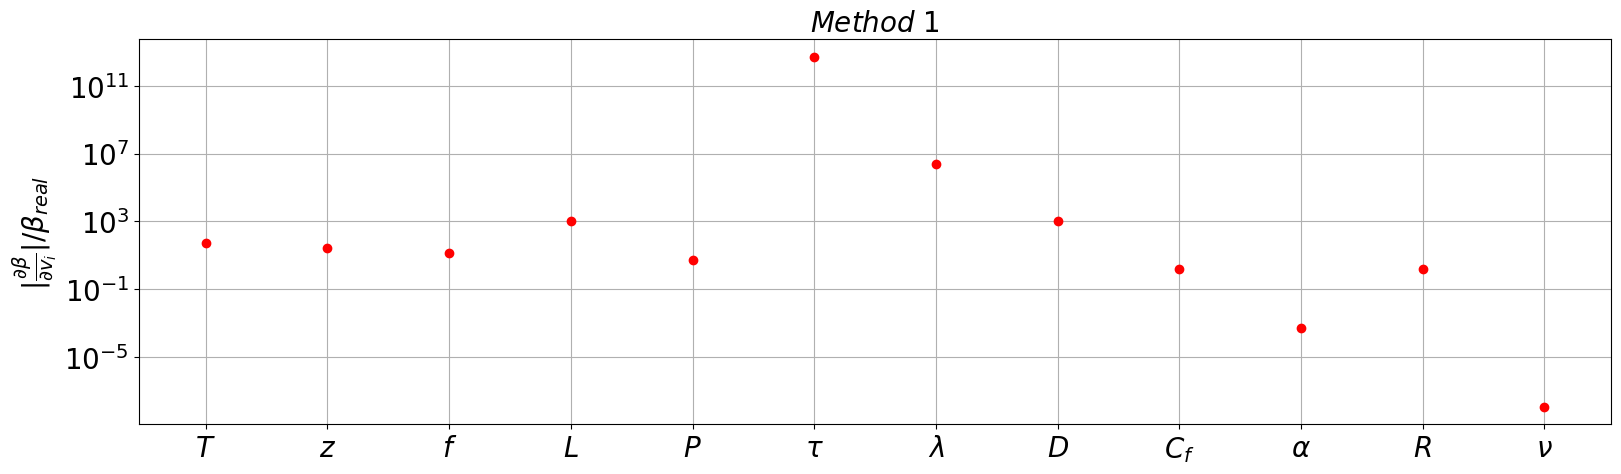

In [44]:
reals=[T_e[index],z_e[index],focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e]
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
l=[r'$T$',r'$z$',r'$f$',r'$L$',r'$P$',r'$\tau$',r'$\lambda$',r'$D$',r'$C_f$',r'$\alpha$',r'$R$',r'$\nu$']
p_max=[i/beta_e  for c,i in enumerate(results)]  # cota maxima
sum_max=np.sqrt(sum(i**2 for i in p_max)) 
f=plt.figure(figsize=(19,5))
plt.grid(True, which="both")
plt.semilogy(l,p_max,'ro')#label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | /\beta_{real}$')
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right |  /\beta_{real}$',fontsize=20)
plt.title('$Method$ $1$',fontsize=20)
plt.show()


# Method 2

$$\sigma^{2}=\sum_{l=1}^{n}\left(\frac{\partial \beta}{\partial x_l} \sigma_{X_l}\right)^{2}+\sum_{l=1}^{n}\left(\frac{\partial \beta}{\partial y_l} \sigma_{Y_l}\right)^{2}+\sum_{i=1}^{N}\left(\frac{\partial \beta}{\partial v_i} \sigma_{V_i}\right)^{2}$$

In [39]:
y_as_strings = ['T'+str(i) for i in range(len(T_e))]
z_as_strings = ['z'+str(i) for i in range(len(T_e))]
y_as_symbol_objects = [sym.symbols(v) for v  in y_as_strings] # Simbolos para y
z_as_symbol_objects = [sym.symbols(v) for v  in z_as_strings] # Simbolos para f
 
def BETA2(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - sym.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(sym.pi*D) # beam waist
    z0 = sym.pi*w0**2/wl # Rayleigh range
    w = w0*(1 + (z/z0)**2)**0.5 # Beam radius
    I0 = 4*(np.log(2))**0.5*Pavg/(Tp*freq*sym.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((z)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def BETA_prime(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq,param):
    return sym.diff(BETA2(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq),param,1)

y_as_symbol_objects=np.array(y_as_symbol_objects)
z_as_symbol_objects=np.array(z_as_symbol_objects)

In [40]:
results1=[]
results2=[]
results3=[]

for i in range(len(T_e)):
    DerivativeOfF = sym.lambdify((y_as_symbol_objects,z_as_symbol_objects, f,L,P,Tp,wl,D,Cf,alfa,R,freq),BETA_prime(y_as_symbol_objects,z_as_symbol_objects, f,L,P,Tp,wl,D,Cf,alfa,R,freq,y_as_symbol_objects[i]),"numpy")
    val=DerivativeOfF(T_e,z_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e)
    results1.append(abs(val))

for i in range(len(z_e)):

    DerivativeOfF = sym.lambdify((y_as_symbol_objects,z_as_symbol_objects, f,L,P,Tp,wl,D,Cf,alfa,R,freq),BETA_prime(y_as_symbol_objects,z_as_symbol_objects, f,L,P,Tp,wl,D,Cf,alfa,R,freq,z_as_symbol_objects[i]),"numpy")
    val=DerivativeOfF(T_e,z_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e)
    results2.append(abs(val))


for i in range(2,12):
    
    DerivativeOfF = sym.lambdify((y_as_symbol_objects,z_as_symbol_objects, f,L,P,Tp,wl,D,Cf,alfa,R,freq),BETA_prime(y_as_symbol_objects,z_as_symbol_objects, f,L,P,Tp,wl,D,Cf,alfa,R,freq,params[i]),"numpy")
    val=DerivativeOfF(T_e,z_e,focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e)
    results3.append(abs(val))

In [41]:
t1=np.sqrt(sum(i**2/beta_e for i in results1))
t2=np.sqrt(sum(i**2/beta_e for i in results2))
t3=[i/beta_e for i in results3]
tf=[t1]+[t2]+t3

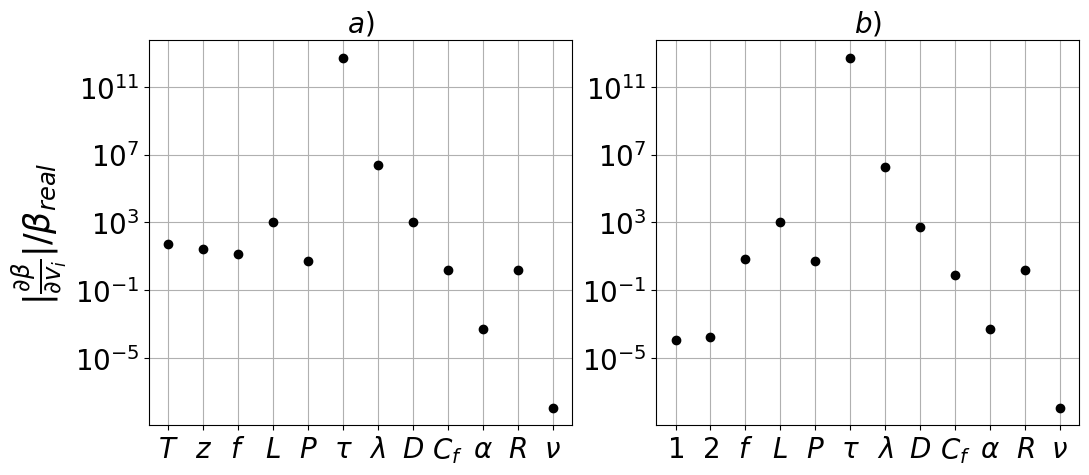

In [45]:
f=plt.figure(figsize=(12,5))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

plt.subplot(121)
reals=[T_e[index],z_e[index],focal_e,L_e,Pavg_e,Tp_e,wl_e,D_e,Cf_e,alfa_e,R_e,freq_e]

l=[r'$T$',r'$z$',r'$f$',r'$L$',r'$P$',r'$\tau$',r'$\lambda$',r'$D$',r'$C_f$',r'$\alpha$',r'$R$',r'$\nu$']
p_max=[i/beta_e  for c,i in enumerate(results)]  # cota maxima
#sum_max=np.sqrt(sum(i**2 for i in p_max)) 

plt.semilogy(l,p_max,'ko')#label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | /\beta_{real}$')
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right |  /\beta_{real}$',fontsize=25)
plt.title('$a)$',fontsize=20)

plt.grid()



plt.subplot(122)
l2=[r'$1$',r'$2$',r'$f$',r'$L$',r'$P$',r'$\tau$',r'$\lambda$',r'$D$',r'$C_f$',r'$\alpha$',r'$R$',r'$\nu$']

plt.semilogy(l2,tf,'ko')#label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | /\beta_{real}$')
#plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right |  /\beta_{real}$',fontsize=20)
plt.title('$b)$',fontsize=20)

plt.grid()





In [ ]:

plt.subplot(122)
plt.plot(l,p_min,'ko',label=r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma^{min}_{v_i}$')
plt.hlines(sum_min,xmin=l[0],xmax=l[-1],color='red',label='$\sigma^{min}_{eff}$')
plt.legend()
plt.ylabel(r'$\left | \frac{\partial \beta}{\partial v_i} \right | \sigma_{v_i}$',fontsize=20)